In [1]:
import mdtraj as md
import pyemma as pm

import openpathsampling as ops
import openpathsampling.visualize as ops_vis

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from pathlib import Path
import os
import pickle
import pandas 
import numpy as np
from IPython.display import SVG

In [236]:
title = 'CLN_tps_test'
storage_path = Path(f'./data/{title}')
results_path = Path(f'./results/{title}')
fig_path = results_path.joinpath('fig')
fig_path.mkdir(parents=True, exist_ok=True)

frame_interval = 1 #ps

In [138]:
storage.schemes[0]

In [139]:
# Load storage in read-only way
storage = ops.AnalysisStorage(os.path.join(storage_path, 'CLN_tps_test.nc'))
engine = storage.engines[1]
scheme = storage.schemes[0]
scheme.move_summary(storage.steps)
print("File size: {0} for {1} steps, {2} snapshots".format(
    storage.file_size_str,
    len(storage.steps),
    len(storage.snapshots)))

  0%|          | 0/1001 [00:00<?, ?it/s]

shooting ran 100.000% (expected 100.00%) of the cycles with acceptance 347/1000 (34.70%)
File size: 5.33GB for 1001 steps, 71628 snapshots


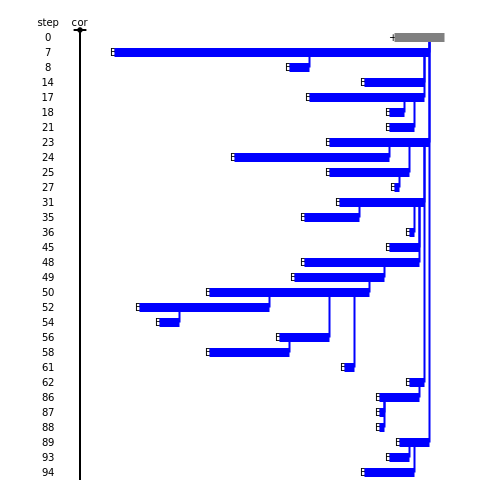

In [140]:
# To visualize the time evolution of samples use pathtree
tree_head = ops_vis.PathTree(
            storage.steps[0:100],
            ops_vis.ReplicaEvolution(replica=0))

tree_full = ops_vis.PathTree(
            storage.steps,
            ops_vis.ReplicaEvolution(replica=0))

SVG(tree_head.svg())

In [141]:
# Count the number of decorrelated trajectories
print(len(tree_full.generator.decorrelated_trajectories))

28


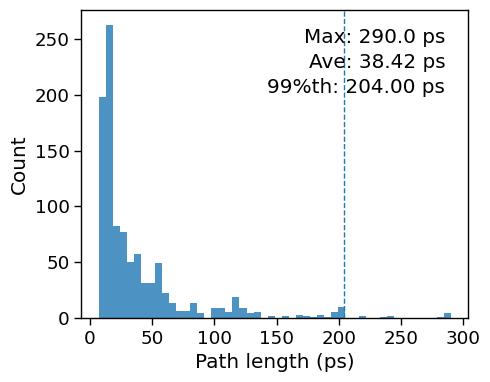

In [185]:
# Path length distribution
# Includes all paths -- paths are kept if its move is rejected 
# Path length distribution gives us an idea of the maximum path length allowed to save computational cost

path_lengths = [len(step.active[0].trajectory) for step in storage.steps]
percentile = np.percentile(path_lengths, 99)

text_0 = f"Max: {max(path_lengths)*engine.snapshot_timestep}"
text_1 = "Ave: " + (np.mean(path_lengths)*engine.snapshot_timestep).format('%.2f')
text_2 = "99%th: " + (percentile*engine.snapshot_timestep).format('%.2f')

with sns.plotting_context('paper', font_scale=1.5):
    fig, ax = plt.subplots(1,1, figsize=(5,4))
    ax.hist(path_lengths, bins=50, alpha=0.8)
    ax.annotate(text=text_0, xy=(0.94,0.94), xycoords='axes fraction', ha='right', va='top')
    ax.annotate(text=text_1, xy=(0.94,0.86), xycoords='axes fraction', ha='right', va='top')
    ax.annotate(text=text_2, xy=(0.94,0.78), xycoords='axes fraction', ha='right', va='top')
    ax.axvline(percentile, ls='--', lw=1)
    
    ax.set_ylabel("Count")
    ax.set_xlabel("Path length (ps)")
    
    plt.savefig(fig_path.joinpath('len_dist.png'), bbox_inches='tight')
    plt.show()

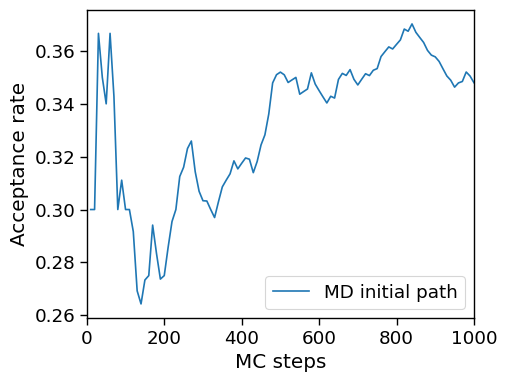

In [186]:
# Plot the smoothed acceptance rate every n=10 MC steps 

move_accepted = [step.change.accepted for step in storage.steps]
n = 10

with sns.plotting_context('paper', font_scale=1.5):
    x = np.arange(n, len(move_accepted)+1, n)
    y = [sum(move_accepted[:i])/i for i in x]
    
    fig, ax = plt.subplots(1,1, figsize=(5,4))
    ax.plot(x, y, label='MD initial path')
    ax.set_xlabel('MC steps')
    ax.set_ylabel('Acceptance rate')
    ax.set_xlim([0, len(move_accepted)])
    ax.legend()
    
    plt.savefig(fig_path.joinpath('accepted_vs_mcstep.png'), bbox_inches='tight')
    plt.show()

In [202]:
accepted_paths = [step.active[0].trajectory.to_mdtraj() for step in storage.steps if step.change.accepted]

In [223]:
# Transfrom a trajectory onto the predifined tica space

model_path = r'./data/CLN/'

with open(os.path.join(model_path, 'msm_models'), 'rb') as f:
    models = pickle.load(f)
tica_mod = models['tica_mod']
kmeans_mod = models['kmeans_mod']
msm = models['msm']


def get_path_tica(traj, tica_mod, f_scheme,):
    path_tica = []
    
    for snapshot in traj:
        snapshot.remove_solvent(inplace=True)
        f_snapshot = md.compute_contacts(snapshot, scheme=f_scheme)[0]
        tica_snapshot = tica_mod.transform(f_snapshot)[0]
        path_tica.append(tica_snapshot)
    return np.array(path_tica)

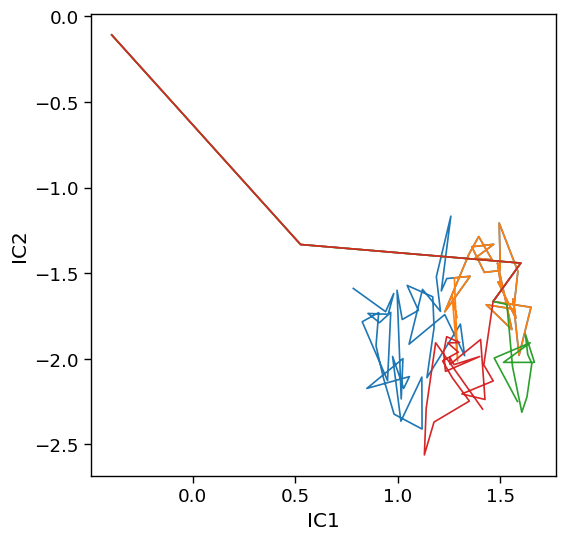

In [232]:
# Path visualisation on TICA
# We may identify multiple transition channels?
# !!! We will need to use consistent order parameters for state definition and path visualisation 

with sns.plotting_context('paper', font_scale=1.5):
    fig, ax = plt.subplots(1,1, figsize=(6,6))
    
    for path in accepted_paths[1:5]:
        x = get_path_tica(path, tica_mod, 'ca')[:,0]
        y = get_path_tica(path, tica_mod, 'ca')[:,1]
        ax.plot(x, y)
        
    ax.set_xlabel('IC1')
    ax.set_ylabel('IC2')
    
    plt.savefig(fig_path.joinpath('accepted_paths.png'), bbox_inches='tight')
    plt.show()

In [234]:
pcca = storage.cvs['pcca_cv']

In [235]:
pcca(storage.steps[231].active[0].trajectory[0])

AttributeError: 'NoneType' object has no attribute 'transform'

In [ ]:
# Path density on membership 
